In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import sklearn.metrics as metrics

In [2]:
# params
learning_rate = 0.01
n_epochs = 1000
train_test_split_ratio = 0.8
lookback = 4
batch_size = 16

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
spy_df = pd.read_csv("../data/spy_data.csv")

In [6]:
timeseries = spy_df[["Close"]].values.astype("float32")

In [7]:
timeseries = [i[0] for i in timeseries]

In [8]:
# convert to 1 for increase and 0 for decrease
labels = [int(i - j > 0) for i, j in zip(timeseries[1:], timeseries[:-1])]

In [9]:
labels = [np.nan] + labels

In [10]:
len(labels), len(timeseries)

(5035, 5035)

In [11]:
# train-test split for time series
train_size = int(len(timeseries) * train_test_split_ratio)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
train_label, test_label = labels[:train_size], labels[train_size:]

In [12]:
train.pop(0)
train_label.pop(0)

nan

In [13]:
def min_max_scaler(series, minimum, maximum):
    return (series - minimum)/(maximum - minimum)

def min_max_inverse_scaler(series, minimum, maximum):
    return (series*(maximum - minimum)) + minimum

def create_dataset(dataset, l, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = [[float(m)] for m in dataset[i:i+lookback]]
#         feature = [[m,n] for m,n in zip(dataset[i:i + lookback], l[i:i+lookback])]
        target = l[i+1:i+lookback+1]
        target = [[float(m)] for m in l[i+1:i+lookback+1]]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [14]:
train = np.array(train)

In [15]:
maximum = train.max()
minimum = train.min()

In [16]:
train = min_max_scaler(train, minimum, maximum)
test = min_max_scaler(test, minimum, maximum)

In [17]:
X_train, y_train = create_dataset(train, train_label, lookback=lookback)
X_test, y_test = create_dataset(test, test_label, lookback=lookback)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [18]:
X_train[1]

tensor([[0.0675],
        [0.0726],
        [0.0715],
        [0.0702]], device='cuda:0')

In [19]:
X_train.shape

torch.Size([4023, 4, 1])

In [20]:
class lstmModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size = 150, num_layers=1,batch_first=True)
        self.linear = nn.Linear(150, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = torch.sigmoid(self.linear(x))
        return x

In [21]:
model =lstmModel()

In [22]:
model.to(device)

lstmModel(
  (lstm): LSTM(1, 150, batch_first=True)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)

In [23]:
optimizer=optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

In [24]:
model.cuda()

lstmModel(
  (lstm): LSTM(1, 150, batch_first=True)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)

In [25]:
X_batch

NameError: name 'X_batch' is not defined

In [26]:
model.train()
for epoch in range(n_epochs):
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.70028
Epoch: 100, loss: 0.66918
Epoch: 200, loss: 0.67717
Epoch: 300, loss: 0.68583
Epoch: 400, loss: 0.69887
Epoch: 500, loss: 0.66811
Epoch: 600, loss: 0.69950
Epoch: 700, loss: 0.69141
Epoch: 800, loss: 0.68612
Epoch: 900, loss: 0.69938


In [27]:
torch.save(model.state_dict(), "only_stock_predict_directionality.pth")

In [29]:
model.load_state_dict(torch.load("first_predict_directionality.pth"))

<All keys matched successfully>

In [28]:
model.eval()

lstmModel(
  (lstm): LSTM(1, 150, batch_first=True)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)

In [29]:
sum([len(i) for i in model.parameters()])

2402

In [30]:
with torch.no_grad():
    # shift test predictions for plotting
    data = model(X_test)
    data = data.cpu()
    test_plot = data[:, -1, :]
    test_plot = list(i[0] for i in test_plot.numpy())

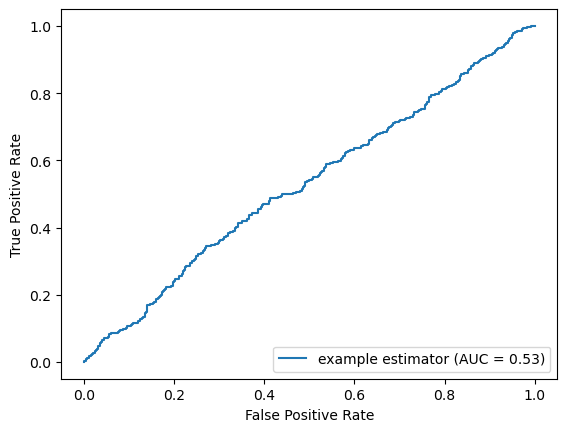

In [31]:
y = np.array(test_label[lookback:])
pred = np.array(test_plot)
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot() 

In [32]:
convert = [int(i > 0.5) for i in pred]

In [33]:
metrics.f1_score(y, np.array([1] * len(y)))

0.7007772020725389

In [34]:
metrics.f1_score(y, convert)

0.7007772020725389

(array([ 47.,  91., 131., 136., 155., 131., 135., 102.,  55.,  20.]),
 array([0.50798136, 0.51358622, 0.51919109, 0.52479601, 0.53040087,
        0.53600574, 0.5416106 , 0.54721546, 0.55282038, 0.55842525,
        0.56403011]),
 <BarContainer object of 10 artists>)

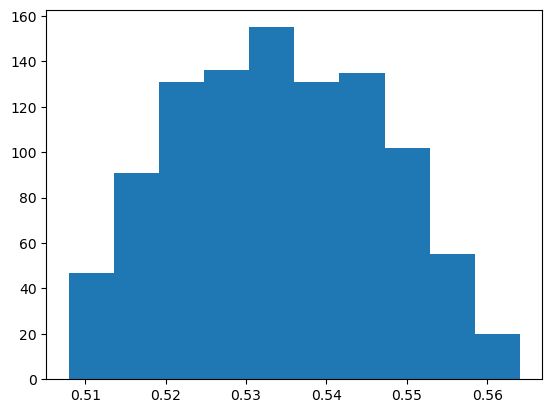

In [39]:
plt.hist(test_plot)

In [37]:
sum(test_plot)/len(test_plot)

0.5341345416465524

In [22]:
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = y_pred.cpu()
    y_pred = y_pred[:, -1, :]
    data = model(X_train)
    data = data.cpu()
    train_plot = data[:, -1, :]
    train_plot = list(i[0] for i in train_plot.numpy())
    train_plot = ([np.nan] * lookback) + train_plot

    # shift test predictions for plotting
    data = model(X_test)
    data = data.cpu()
    test_plot = data[:, -1, :]
    test_plot = list(i[0] for i in test_plot.numpy())
    test_plot = ([np.nan] * (train_size+lookback)) + test_plot
    

tseries = [i[0] for i in timeseries]
train_plot_unscaled = [i*(maximum - minimum) + minimum for i in train_plot]
test_plot_unscaled = [i*(maximum - minimum) + minimum for i in test_plot]

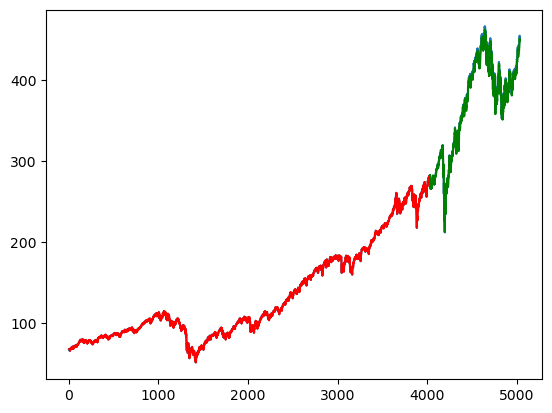

In [23]:
# # plot
plt.plot(timeseries)
plt.plot(train_plot_unscaled, c='r')
plt.plot(test_plot_unscaled, c='g')
plt.show()

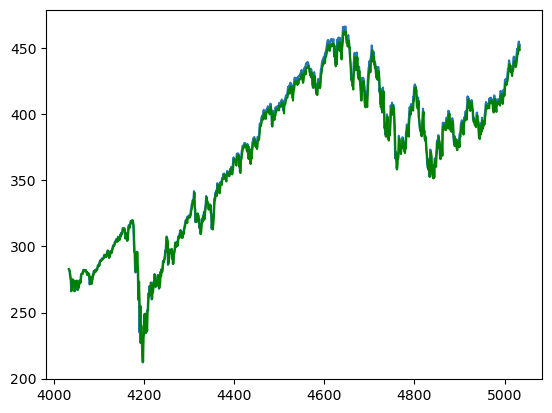

In [88]:
# # plot
plt.plot(([np.nan] * (train_size+lookback)) + tseries[lookback + train_size:])
plt.plot(test_plot_unscaled, c='g')
plt.show()

In [69]:
diff_train = [(i - j) if i != np.nan else 0 for i, j in  zip(train_plot_unscaled, tseries)]

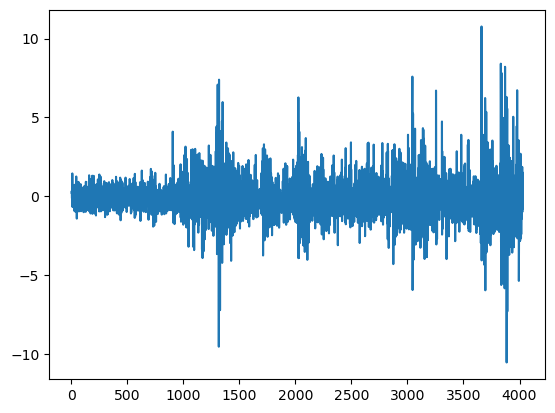

In [70]:
plt.plot(diff_train)

In [71]:
diff_test = [(i - j) if i != np.nan else 0 for i, j in  zip(test_plot_unscaled, tseries)]

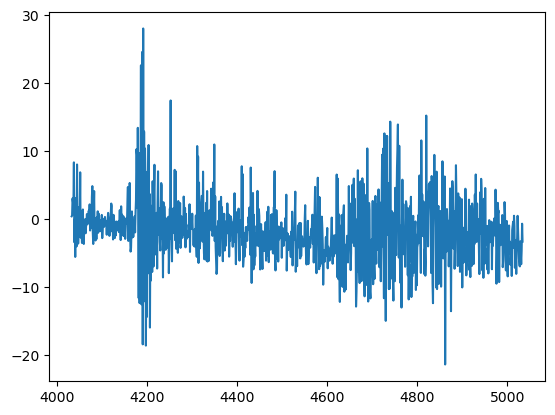

In [72]:
plt.plot(diff_test)

In [80]:
sq_diff_test = [i**2 for i in diff_test][train_size + lookback:]

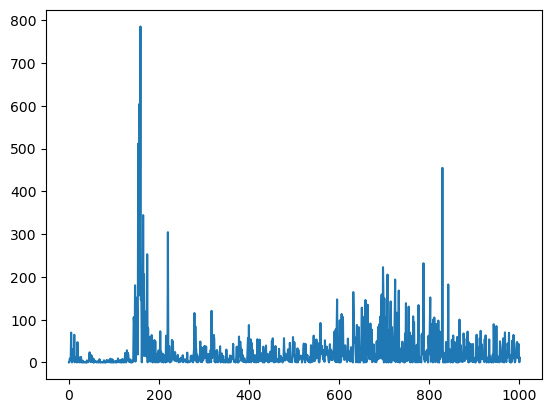

In [101]:
plt.plot(sq_diff_test)

In [85]:
(sum(sq_diff_test)/len(sq_diff_test))**0.5

5.068020776701268

In [43]:
y_train = np.array(timeseries[lookback:train_size])
yhat_train = np.array(train_plot_unscaled[lookback:])

y_test = np.array(timeseries[lookback + train_size:])
yhat_test = np.array(test_plot_unscaled[lookback + train_size:])

In [104]:
baseline = tseries[lookback + train_size - 1:-1]
baseline = np.array(baseline)
full_data = np.array(tseries[lookback + train_size:])

In [105]:
len(full_data) == len(baseline)

True

In [106]:
# get MSE and R
# baseline
mse_base = metrics.mean_squared_error(full_data, baseline)
rmse_base = np.sqrt(mse_base) # or mse**(0.5)  
mape_base = metrics.mean_absolute_percentage_error(full_data, baseline)
r2_base = metrics.r2_score(full_data,baseline)

# Train
mse_train = metrics.mean_squared_error(y_train, yhat_train)
rmse_train = np.sqrt(mse_train) # or mse**(0.5)  
mape_train = metrics.mean_absolute_percentage_error(y_train, yhat_train)
r2_train = metrics.r2_score(y_train,yhat_train)

# test
mse_test = metrics.mean_squared_error(y_test, yhat_test)
rmse_test = np.sqrt(mse_test) # or mse**(0.5)  
mape_test = metrics.mean_absolute_percentage_error(y_test, yhat_test)
r2_test = metrics.r2_score(y_test,yhat_test)

In [111]:
rmse_base, mape_base*100, r2_base

(4.734509, 0.9540571831166744, 0.9935486539062184)

In [112]:
rmse_train, mape_train*100, r2_train

(1.3285704, 0.7217078469693661, 0.9994911137539784)

In [113]:
rmse_test, mape_test*100, r2_test

(5.068021, 1.0497327893972397, 0.9926149974484703)

In [134]:
train_diff = [bool(i - j > 0) for i, j in zip(timeseries[lookback:train_size], timeseries[lookback -1:train_size-1])]

In [132]:
train_diffhat = [bool(i - j > 0) for i, j in zip(np.array(train_plot_unscaled[lookback:]), timeseries[lookback -1:train_size-1])]

In [137]:
metrics.f1_score(np.array(train_diff), np.array(train_diffhat))

0.5309941520467836

In [140]:
acc = sum([i == j for i, j in zip(train_diff, train_diffhat)]) / len(train_diff)

In [141]:
acc

0.5017395626242545

In [139]:
metrics.accuracy(np.array(train_diff), np.array(train_diffhat))

AttributeError: module 'sklearn.metrics' has no attribute 'accuracy'

In [127]:
yhat_train

array([ 68.270966,  68.075165,  67.773895, ..., 279.07574 , 280.02808 ,
       278.4328  ], dtype=float32)

In [120]:
# what if i changed the question to up or down?

direction = [i - j > 0 for i, j in zip(tseries[lookback + 1:], tseries[lookback:-1])]

In [121]:
direction

[False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 T